# Stocks Prediction

## Author: Edi Buslovich


## Main Objective: 
Make money by stock prediction.
<br>
Personally I have savings that I use to privately buy ETFs for the purpose of long term investment.
<br>
I don't invest in single stocks because they are too unpredictable and it's difficult to maintain stable revenues from them.
<br>
If it will be possible to gain any advantage of the market that will be proven for a long period, I'd love to use it for my own benefit.

## Personal project goals:
* Learn the complexity of stocks prediction
* Learn the modern data science eco system and the tools
* Feel what it's like to be a beginner data scientist without a PhD and how much progress is possible in that role
* Try to get a little value from any kind of prediction model in that project

## Assumptions:
* It's very difficult to create a prediction that will hit the market
* Many people and companies have already tried that for decades
* Any existing blog / academic essay will be just an intro to this world and will not actually present an algorithm to "make money"
* As a result of the above, I believe that any small progress will be achieved by trial and error and "out of the box" ideas for data sets and methods
* Compute power that's needed for realtime prediction should be considered as one of the "fees" for the stocks trading

## Data Set
The project proposal relies on all historical data of the FB stock (Facebook).
<br>
The data is 1 day grnaularity and includes the Open/Close/Volume of every day since the stock exists.
<br>
Any historical data of a stock can be downloaded easily as a CSV from Yahoo Finance.
<br>
Example for FB stock [here](https://finance.yahoo.com/quote/FB/history?p=FB) (click on "Download Data" button).


## Initial Plan
1. Inspect the data of the stock and prepare it for linear regression
1. Try to predict the "Close" price of the next day based on the "Close" prices of last 7 days - use linear regression
1. Check how good the model performs on test set data and whether it's good to use in real life
1. Plan how to improve the model

In [1]:
import os
import math
import random
import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as dates
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Load the data:

In [2]:
df = pd.read_csv("data/facebook.csv", engine='python')
df.loc[:, 'Date'] = pd.to_datetime(df['Date'] ,format='%Y-%m-%d')
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1721,2019-03-25,163.000000,166.539993,162.000000,166.289993,166.289993,12631200
1722,2019-03-26,167.350006,169.449997,166.350006,167.679993,167.679993,15437900
1723,2019-03-27,167.850006,168.940002,164.789993,165.869995,165.869995,10620300
1724,2019-03-28,164.570007,166.720001,163.330002,165.550003,165.550003,10689200
1725,2019-03-29,166.389999,167.190002,164.809998,166.690002,166.690002,13453700


## Inspect the values:

In [3]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1726.000000,1726.000000,1726.000000,1726.000000,1726.000000,1.726000e+03
mean,100.792491,101.877306,99.666756,100.815956,100.815956,3.544349e+07
std,52.974368,53.396935,52.567801,53.036202,53.036202,3.079626e+07
min,18.080000,18.270000,17.549999,17.730000,17.730000,5.913100e+06
25%,58.104999,59.044999,57.182499,57.974999,57.974999,1.801812e+07
50%,97.159999,98.125000,95.375000,97.025002,97.025002,2.573325e+07
75%,147.622498,148.825001,145.767494,147.522495,147.522495,4.316568e+07
max,215.720001,218.619995,214.270004,217.500000,217.500000,5.735764e+08


In [4]:
# Check for NA values
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
# Remove unused columns
df.drop(columns="Adj Close", inplace=True)

In [6]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2012-05-18,42.049999,45.000000,38.000000,38.230000,573576400
1,2012-05-21,36.529999,36.660000,33.000000,34.029999,168192700
2,2012-05-22,32.610001,33.590000,30.940001,31.000000,101786600
3,2012-05-23,31.370001,32.500000,31.360001,32.000000,73600000
4,2012-05-24,32.950001,33.209999,31.770000,33.029999,50237200


## Plot the 4 daily price values

Text(0, 0.5, 'Price [$]')

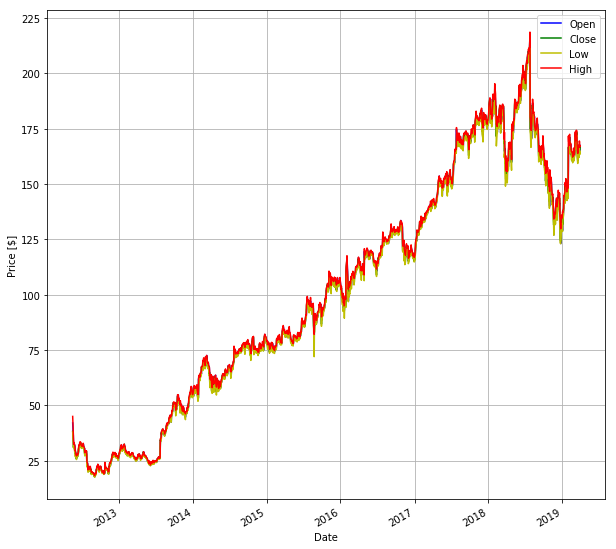

In [7]:
rcParams['figure.figsize'] = 10, 10

ax = df.plot(x='Date', y='Open', style='b-', grid=True)
ax = df.plot(x='Date', y='Close', style='g-', grid=True, ax=ax)
ax = df.plot(x='Date', y='Low', style='y-', grid=True, ax=ax)
ax = df.plot(x='Date', y='High', style='r-', grid=True, ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Price [$]")

It looks like these values have strong correlations between every day.

## Check the volume over time:

Text(0.5, 1.0, 'Stock volume')

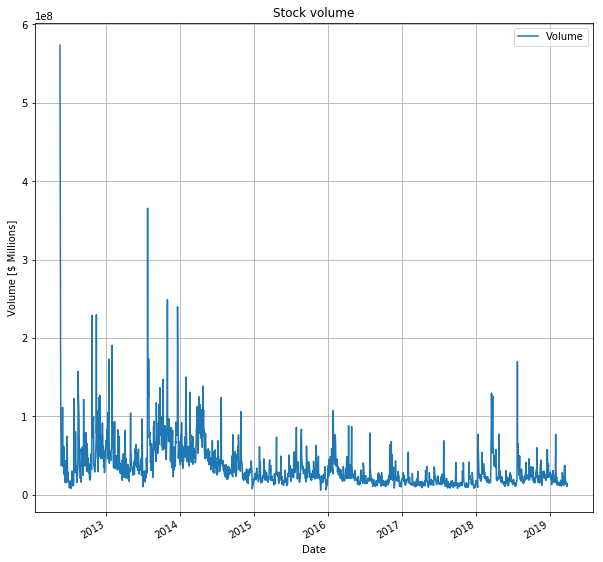

In [8]:
ax = df.plot(x='Date', y='Volume', grid=True)
ax.set_xlabel("Date")
ax.set_ylabel("Volume [$ Millions]")
plt.title("Stock volume")

It looks like the volume doesn't have correlation with the 4 price features.
<br>
We may use it later.

## Try to predict the Close of tomorrow according to Close of last 7 days

In [9]:
df.head(10)

,Date,Open,High,Low,Close,Volume
0,2012-05-18,42.049999,45.000000,38.000000,38.230000,573576400
1,2012-05-21,36.529999,36.660000,33.000000,34.029999,168192700
2,2012-05-22,32.610001,33.590000,30.940001,31.000000,101786600
3,2012-05-23,31.370001,32.500000,31.360001,32.000000,73600000
4,2012-05-24,32.950001,33.209999,31.770000,33.029999,50237200
5,2012-05-25,32.900002,32.950001,31.110001,31.910000,37149800
6,2012-05-29,31.480000,31.690001,28.650000,28.840000,78063400
7,2012-05-30,28.700001,29.549999,27.860001,28.190001,57267900
8,2012-05-31,28.549999,29.670000,26.830000,29.600000,111639200
9,2012-06-01,28.889999,29.150000,27.389999,27.719999,41855500


### Explanation:
Let's try to predict the Close of tomorrow based on the Close of the last 7 days.
<br>
Since we are dealing with time series data, our X values are the date-time and the Y values are the Close price of the corresponding days.
<br>
We use samples of last 7 days to train the linear regression model, and then predict the 8th day using the model.
<br>
The X values should be normalized, so we use the day index (0-6) instead of the date.
<br>
The following code predicts a single day and plots the actual results versus the model's hypotheses linear function.

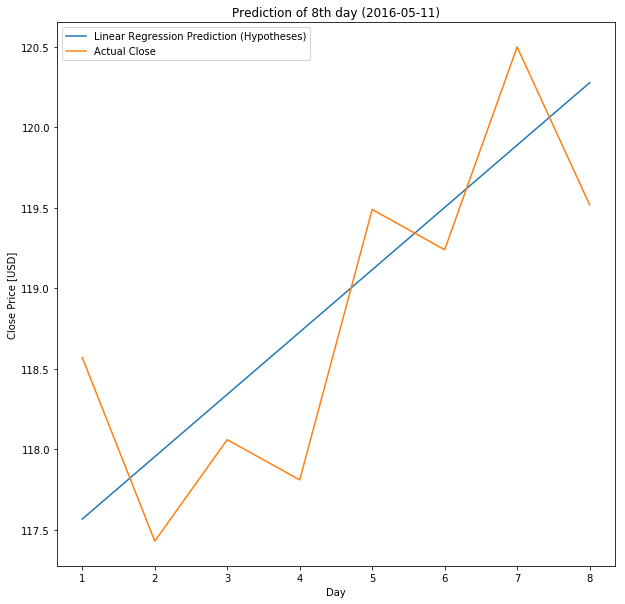

In [10]:
# Init vars
# 1000th day is chosen arbitrarily to be the day that we want to predict
cur_day = 1000
# We will use a week of past data to train our model
window_size = 7
model = LinearRegression()
actuals = []
predictions = []

# Calc the window size of the training set
samples_start = cur_day - window_size
samples_end = cur_day - 1

# The X is the features vector and it includes just an index because we're using time series data
# X - index
# Y - actual Close values
X = np.array(range(samples_start, samples_end + 1))
Y = np.array(df["Close"][samples_start:samples_end + 1])
X = X.reshape(window_size, 1)
Y = Y.reshape(window_size, 1)

# Train the model
model.fit(X, Y)

# Get the linear hypotheses - the line that fits the trained data
predictions = model.predict(np.array(range(samples_start, samples_end + 2)).reshape(window_size + 1, 1))
predictions.shape = (8,)

# Plot the data
actuals = np.array(df["Close"][samples_start:samples_end + 2])
plt.plot(range(1,9), predictions, '-')
plt.plot(range(1,9), actuals, '-')
predicted_date = df.iloc[cur_day]["Date"]
plt.title("Prediction of 8th day ({})".format(predicted_date.date()))
plt.xlabel('Day')
plt.ylabel('Close Price [USD]')
plt.legend(["Linear Regression Prediction (Hypotheses)", "Actual Close"])

**The last day in the diagram is the predicted day**, and we can see the diff between the prediction and the actual value.
<br>
Now we should calculate the root mean squared error:

### Check RMSE (root mean square error) of the predicted day:

In [11]:
predicted = predictions[-1]
actual = actuals[-1]
root_mse = math.sqrt(mean_squared_error([predicted], [actual]))
print("Actual: {}, Predicted: {}, Root Mean Squared Error: {}".format(actual, predicted, root_mse))

Actual: 119.519997, Predicted: 120.27714114285709, Root Mean Squared Error: 0.7571441428570864


Looks pretty small, which is good. But to get any insights we'll need to calculate it on more samples, plus use other metrics.


### Make predictions on the last 100 days
Let's try to do the same process, but for the last 100 days of data.
Then plot the predictions on a graph next to the actual values.

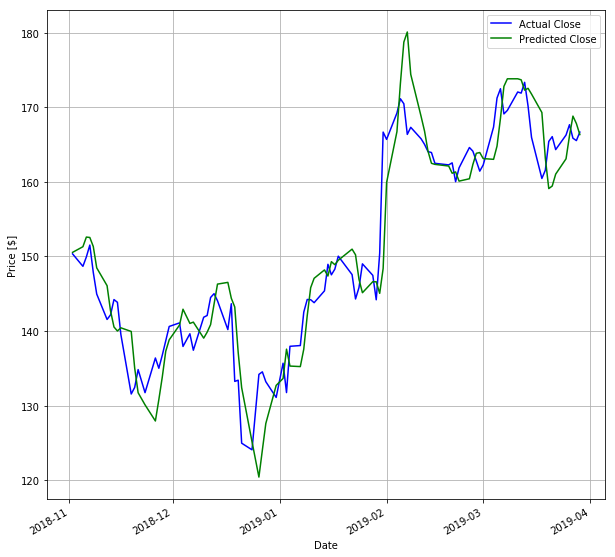

In [12]:
def predict_close_linear_regression(df, cur_day, num_of_days, window_size=7):
    model = LinearRegression()

    actuals = []
    predictions = []

    # Go through all requested days and make a new traigning for every day
    for i in range(cur_day, cur_day + num_of_days):
        # For each day, train a new model using Close values of previous days.
        # Number of previous days is defined by "window_size"
        samples_start = i - window_size
        samples_end = i - 1

        # The X is the features vector and it includes just an index because we're using time series data
        # X - index
        # Y - actual Close values
        X = np.array(range(samples_start, samples_end + 1))
        Y = np.array(df["Close"][samples_start:samples_end + 1])
        X = X.reshape(window_size, 1)
        Y = Y.reshape(window_size, 1)

        # Train the model
        model.fit(X, Y)

        # Predict current day according to the linear regression trained model
        cur_day_prediction = model.predict(np.array([i]).reshape(1, 1))[0][0]
        predictions.append(cur_day_prediction)

        cur_day_actual = df.iloc[i]["Close"]
        actuals.append(cur_day_actual)

    # Build a DataFrame that includes the actual and predicted results on the given data set
    df_results = df.iloc[first_day:first_day + num_of_days]
    df_results = df_results.drop(columns=["Open", "High", "Low", "Volume"])
    cols_pred = pd.Series(predictions, index=range(cur_day, cur_day + num_of_days))
    df_results["Prediction"] = pd.Series(cols_pred)
        
    return actuals, predictions, df_results

# Show actual vs predicted for the last 100 days
numebr_of_days = 100
first_day = len(df) - numebr_of_days
res_actuals, res_predicted, df_results = predict_close_linear_regression(df, first_day, numebr_of_days)

ax = df_results.plot(x='Date', y='Close', style='b-', grid=True)
ax = df_results.plot(x='Date', y='Prediction', style='g-', grid=True, ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Price [$]")
ax.legend(["Actual Close", "Predicted Close"])

For me the predicted data looks good on the graph.
<br>
But it's not enough. We'll need to measure it.
<br>
Again, measure the RMSE metric for the last 100 days:

In [13]:
df_results.head()

,Date,Close,Prediction
1626,2018-11-02,150.350006,150.552856
1627,2018-11-05,148.679993,151.311432
1628,2018-11-06,149.940002,152.604285
1629,2018-11-07,151.529999,152.550001
1630,2018-11-08,147.869995,151.345714


In [14]:
# Calc root mean squared error for the last 1000 days
numebr_of_days = 1000
first_day = len(df) - numebr_of_days
res_actuals, res_predicted, df_results = predict_close_linear_regression(df, first_day, numebr_of_days)
root_mse = math.sqrt(mean_squared_error(res_actuals, res_predicted))
print("RMSE of last 100 days: {}".format(root_mse))

RMSE of last 100 days: 3.661184398660034


Now the RMSE is much higher.

## Finding the best window size
Let's try to run the same process on different window size in order to see if the size of the actual values has any impact on the predicted data.

### First, let's split the data sets:
The actual vs test are separated by a moving window.
<br>
But we still need to split the data in order to be able to validate different parameters:

* 60% training set
* 20% cross validation set
* 20% testing set


In [15]:
# Split into Training, Cross Validation and Testing sets.
set_sizes = {
    "total_size": len(df),
    "train_size": int(len(df) * 0.6),
    "cv_size": int(len(df) * 0.2),
    "test_size": int(len(df) * 0.2)
}

df_train = df.iloc[:set_sizes["train_size"]]
df_train.tail()
df_cv = df.iloc[set_sizes["train_size"]:set_sizes["train_size"] + set_sizes["cv_size"]]
df_cv.tail()
df_cv.index = range(len(df_cv))
df_test = df.iloc[set_sizes["train_size"] + set_sizes["cv_size"]:]
df_test.index = range(len(df_test))

set_sizes

{'total_size': 1726, 'train_size': 1035, 'cv_size': 345, 'test_size': 345}

### Run the prediction on the training set and try windows sizes of 1-10

In [16]:
# Check root MSEs and R^2 with different window sizes
def check_errors(df_set):
    root_mses = []
    r2s = []
    first_day = 10
    numebr_of_days = len(df_set) - first_day
    for ws in range(1, 10):    
        res_actuals, res_predicted, df_results = predict_close_linear_regression(df_set, first_day, numebr_of_days, window_size=ws)

        root_mses.append(math.sqrt(mean_squared_error(res_actuals, res_predicted)))
        r2s.append(r2_score(res_actuals, res_predicted))
    
    return root_mses, r2s

root_mses, r2s = check_errors(df_train)

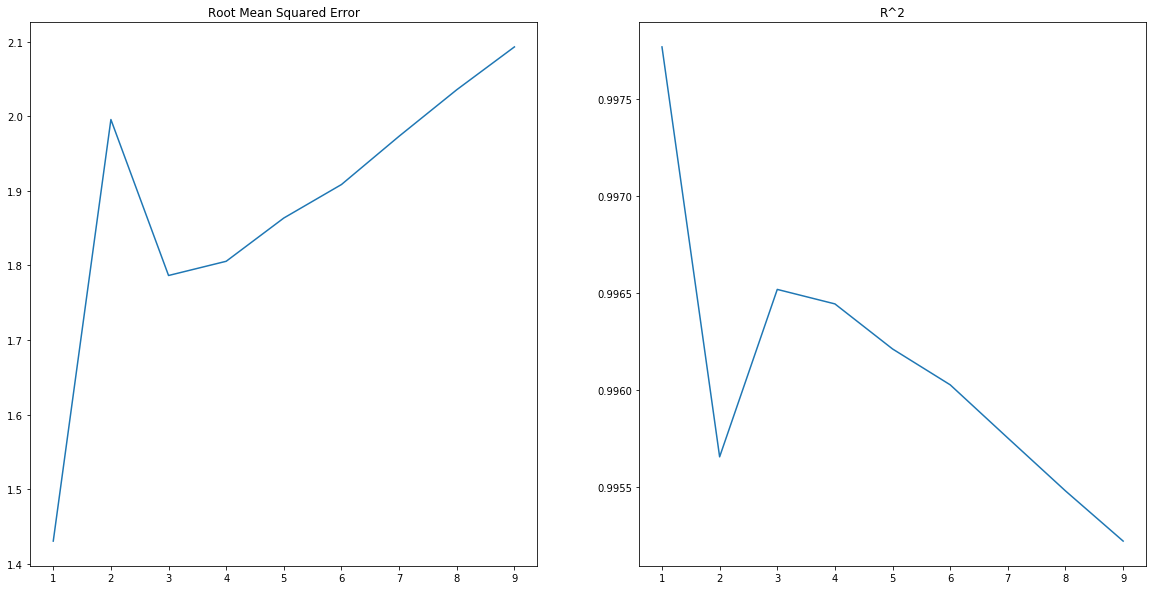

In [17]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(range(1,10), root_mses, '-')
plt.title("Root Mean Squared Error")

plt.subplot(1,2,2)
plt.plot(range(1,10), r2s, '-')
plt.title("R^2")

plt.show()

We can see that the lowest RMSE is when the windows size is 3.
<br>
The corresponding R^2 is the highest, which means the highest accuracy.
<br>
It's also pretty close to 1 (99.65% accuracy).
<br>
But is it good enough?
<br>
Let's first check the errors on the cross validation set:

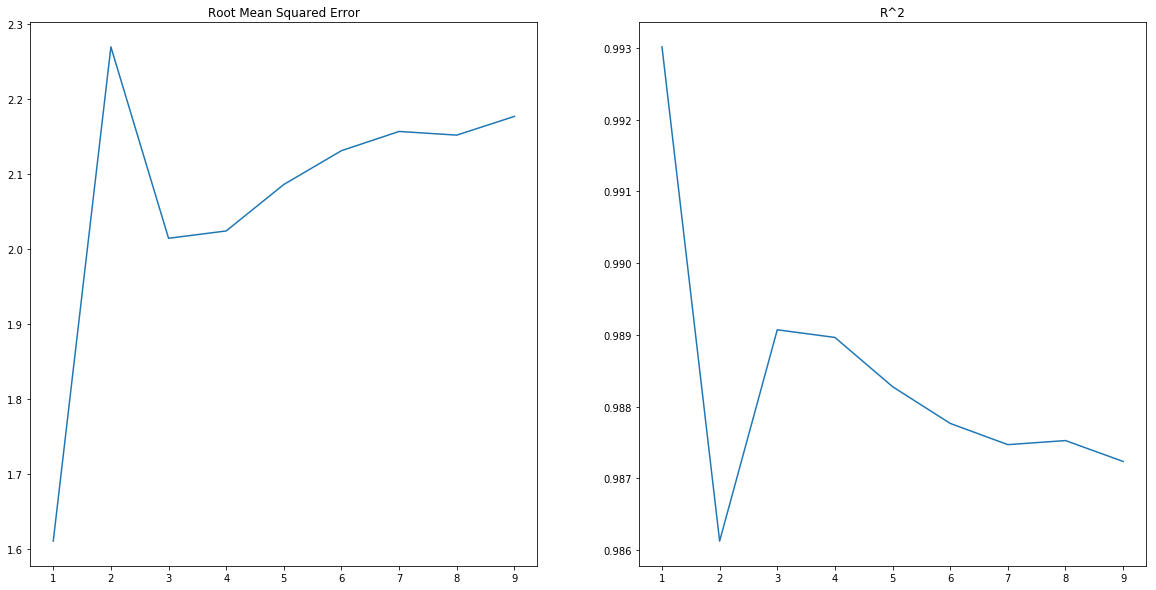

In [18]:
root_mses, r2s = check_errors(df_cv)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(range(1,10), root_mses, '-')
plt.title("Root Mean Squared Error")

plt.subplot(1,2,2)
plt.plot(range(1,10), r2s, '-')
plt.title("R^2")

plt.show()

Looks like the best window size here is also 3, but it's that clear when comparing with the graphs for the 
training data set.
<br>
Let's check the testing data set:

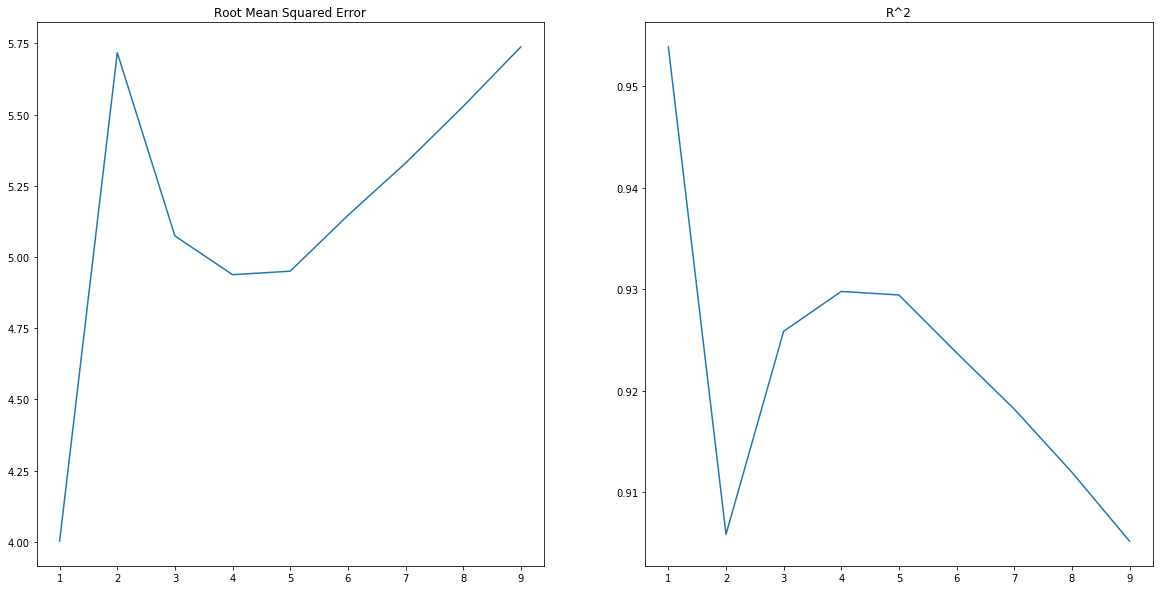

In [19]:
root_mses, r2s = check_errors(df_test)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(range(1,10), root_mses, '-')
plt.title("Root Mean Squared Error")

plt.subplot(1,2,2)
plt.plot(range(1,10), r2s, '-')
plt.title("R^2")

plt.show()

On the training data set the best window size is 4.
<br>
Let's choose 4 and try to make a simulation of buying stocks during the days of the training data set using the prediction and using window size of 4.
<br>

## Simulation of buying stocks using our prediction model results
The simulation is pretty straightforward.
<br>
We go through every day in the data set and check whether the prediction of tomorrow's Close price is lager that the Close price of today.
<br>
If yes, then we buy this stock and sell it tomorrow.
<br>
This simulates a real world scenario where at the end of the trading day we already know the Close price, and this will be the Open price of tomorrow. So tomorrow morning we can buy the stock at the same price of yesterday's Close.
<br>
Then on the day after we sell the stock in the morning at the same price of the actual Close price (of previous day).
<br>
We buy an aritrary number of stock units using this method and then we compare it with a different simulation of buying stocks the same way, but the decision whether to buy or not is random.
<br>
The simulation is not accurate of course, because it doesn't take into account fees and also the small drop/increase in the stock price at the beginning of the trading day.

In [20]:
def simulate_buy(df, stock_units, sim_type):
    random.seed(datetime.datetime.now())
    bought = False
    buy_price = 0

    stats = {
        "transactions_count": 0,
        "total_bought": 0,
        "total_revenue": 0,
        "period_days": len(df)
    }

    for i in range(len(df)):
        tomorrow_close_prediction = df.iloc[i]["Prediction"]
        today_close = df.iloc[i]["Close"]

        # Sell what we bought yesterday (if we bought any)
        if bought:
            sell_price = today_close * stock_units
            revenue = (sell_price - buy_price)
            buy_price = 0
            stats["total_revenue"] += revenue
            bought = False

        # Buy next day
        if sim_type == "prediction":
            should_buy = today_close < tomorrow_close_prediction
        else:
            should_buy = random.randint(1, 2) == 1

        if should_buy:
            # Buy
            bought = True
            buy_price = today_close * stock_units
            stats["total_bought"] += buy_price
            stats["transactions_count"] += 1

    return stats

### Train the model (on the testing set) and run a simulation of buying stocks based on the predictions

In [21]:
# Use window size of 4
ws = 4
first_day = ws
numebr_of_days = len(df_test) - ws

# Make predictions
res_actuals, res_predicted, df_results = predict_close_linear_regression(df_test, first_day, numebr_of_days, window_size=ws)

# Simulate buying stocks daily by relying on prediction
stats_prediction = simulate_buy(df_results, 5, sim_type="prediction")

### Run a simulation of buying stocks based on random decision

In [22]:
# Simulate buying stocks daily randomly (try 100 times)
total_revenues = []
for i in range(100):
    stats_randomly = simulate_buy(df_results, 5, sim_type="random")
    total_revenues.append(stats_randomly["total_revenue"])
mean_simulate_random = np.mean(total_revenues)

### Display the results

In [23]:
# If we just bought at the beginning of the year the same amount of stocks and then sold a the end of the year
# then how much will be the total revenue?
# (This situation is not really possible and not comparable to anything)
year_revenue_percents = 100 * (1 - (df_results.iloc[-1]["Close"] / df_results.iloc[0]["Close"]))
year_possible_revenues = (year_revenue_percents / 100) * stats_prediction["total_bought"]

print("Simulation using prediction. Bought totally ${} and have revenue of ${}".format(int(stats_prediction["total_bought"]), int(stats_prediction["total_revenue"])))
print("Simulation using random transactions. Mean revenues: ${}, Yearly revenue: ${}".format(int(mean_simulate_random), int(year_possible_revenues)))

Simulation using prediction. Bought totally $143896 and have revenue of $110
Simulation using random transactions. Mean revenues: $-11, Yearly revenue: $10336


### From the results we learn that:
* We can see that if buy stocks and sell them on the day after by random decision, the performance is pretty bad - we lose money.
* On the other hand if we use the predicted values, we can earn money (!).
* However, it's still not that good because with our model, we'll need to spend \\$143,896 in order to earn just \\$110.
* In theory, if we would have taken this amount of money at the beginning of the training set period and buy all the stocks with them, and then sold the stocks at the end of the period, we could earn \\$10,336 (a revenue of 7%).
* This gets even worser, because the yearly revenue from this stock was 7%, it should be easy to earn money in a rising market. What would have happened if the market was going down or even worse, was very volatile?

## Initial Conclusions
1. It's really not that easy to outperform
1. Even though the error is very low, the simulation shows that the predictions are not good enough (need to understand why and how to analyze the error)
1. Linear regression is a very simple model, which is a good introduction to this world but can barely fit the actual values

## What's next? 
### The plan:
1. Understand how to treat the errors
1. Normalize the data and try Polynomial Regression to better fit the actual values
1. Apply ANN MLPClassifier for predicting the stock close price on next day according to today's Open/Close/Volume - use a rule of thumb for the decision of whether to buy/not buy the stock on the day after
1. Learn LSTM RNN and Keras in order to fit the model with time series moving window, the same way I did here but with all 4 price features and Volume

### General ideas:
1. Train the model on all stocks of NASDAQ seperately to get a general prediction and use its prediction as an input parameter to the decision whether to buy the stock or not
1. Use news insights as a feature for the prediciton model (Reuters API allows 500 free requests per day)
1. Try other features, for example accounting data
1. Try other prediction goals, for example predicting something else that can be useful other than "Close" price